# TP4
El archivo data.csv contiene una lista de publicaciones de f ́ısica de altas energ ́ıas del repositorio ArXiv. En esta pr ́actica vamos a estudiar el grafo de colaboraciones entre autores, en el que los nodos representan autores y las aristas coautor ́ıas. Vamos a usar un grafo simple no dirigido, en el que basta una coautor ́ıa para que haya una conexi ́on entre dos autores.

Imports

In [127]:
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import networkx as nx
import itertools
import random
from collections import Counter
sns.plt = plt

## 1. Creacion del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el numero de nodos y aristas. Haga una representacion grafica del grafo.

Lectura de datos

In [38]:
df = pd.read_csv('data.csv',
                 header=None,
                 names=['year', 'journal', 'media', 'authors', 'paper_name'],
                 usecols=['authors'])

# print df

Preprocesamiento - Creacion del grafo

In [37]:
coauthor_graph = nx.Graph()
for index, row in df.iterrows():
    paper_authors = row['authors'].split("&")
    paper_authors_pairs = list(itertools.combinations(paper_authors, 2))
    coauthor_graph.add_nodes_from(paper_authors)
    coauthor_graph.add_edges_from(paper_authors_pairs)

AttributeError: 'float' object has no attribute 'split'

Imprimir el numero de nodos y aristas.

In [46]:
print "Numero de nodos: " + str(coauthor_graph.number_of_nodes())
print "Numero de aristas: " + str(coauthor_graph.number_of_edges())

Numero de nodos: 4430
Numero de aristas: 6537


Hacer una representacion grafica del grafo.

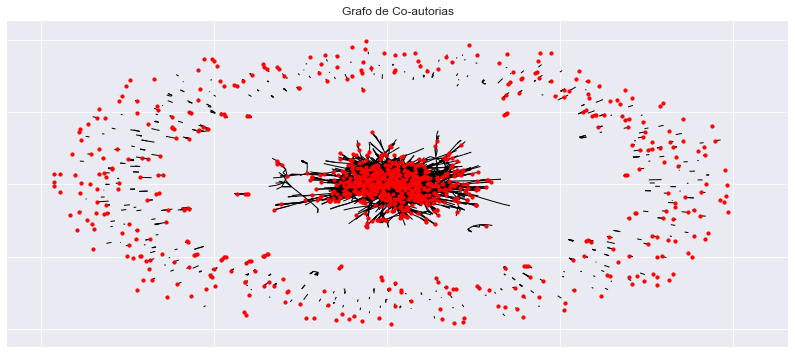

In [98]:
nodes_visible = random.sample(coauthor_graph.nodes(), 1000)
nx.draw_networkx(coauthor_graph, with_labels=False, node_size=10, nodelist = nodes_visible)
plt.tick_params(axis='x', labelbottom='off')
plt.tick_params(axis='y', labelleft='off')
plt.title("Grafo de Co-autorias")
plt.rcParams["figure.figsize"] = [14,6]
plt.show()

## 2. Distribucion de Grado
Grafique la distribucion del grado de los autores, en escalas lineales, semilogaritmica, y log-log. Argumente, a partir de los graficos, de que tipo de distribucion se trata.

In [134]:
author_degree_list = list(coauthor_graph.degree())
degree_list = [degree for (author, degree) in author_degree_list]

degree_frequencies = Counter(degree_list)
print degree_frequencies

Counter({1: 1113, 2: 939, 3: 600, 0: 552, 4: 384, 5: 237, 6: 160, 7: 117, 8: 78, 9: 61, 10: 37, 11: 34, 12: 26, 13: 17, 14: 15, 15: 14, 16: 9, 17: 9, 18: 8, 20: 8, 19: 2, 21: 2, 22: 1, 23: 1, 26: 1, 27: 1, 31: 1, 32: 1, 35: 1, 36: 1})


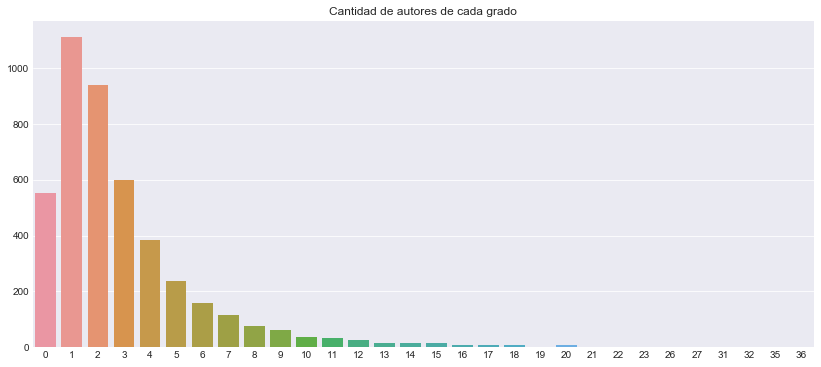

In [135]:
ax = sns.barplot(degree_frequencies.keys(), y=degree_frequencies.values())
plt.title("Cantidad de autores de cada grado")
plt.show()

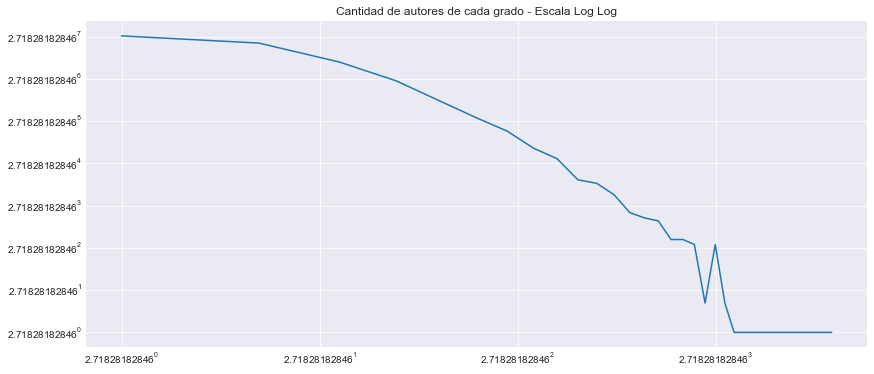

In [141]:
plt.loglog(degree_frequencies.keys(), degree_frequencies.values(), basex=np.e, basey=np.e)
plt.title("Cantidad de autores de cada grado - Escala Log Log")

plt.show()

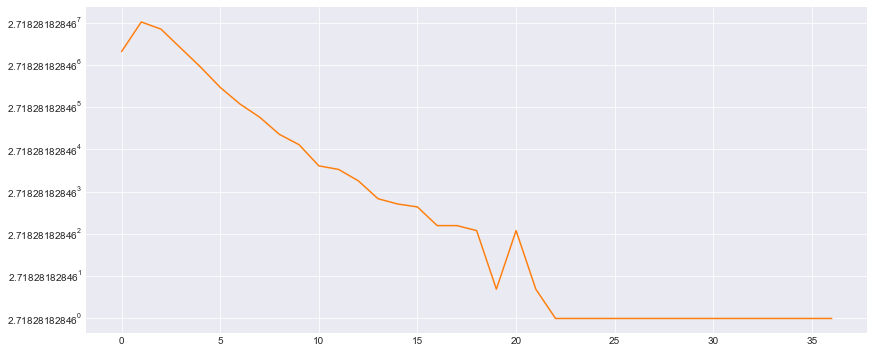

In [140]:
plt.semilogy(degree_frequencies.keys(), degree_frequencies.values(), basey=np.e)
plt.title("Cantidad de autores de cada grado - Semilog")
plt.show()